<a href="https://colab.research.google.com/github/rabby575-png/CVPR/blob/main/MID/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment: Implementation of a Three Hidden Layer Neural Network for Multi-Class Classification

Name: MD GOLAM RABBY

ID: 22-48682-3

Sec: C

In [1]:

import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)


Dataset shape: (1000, 2)
Label shape  : (1000,)
Classes      : [0 1 2 3 4]


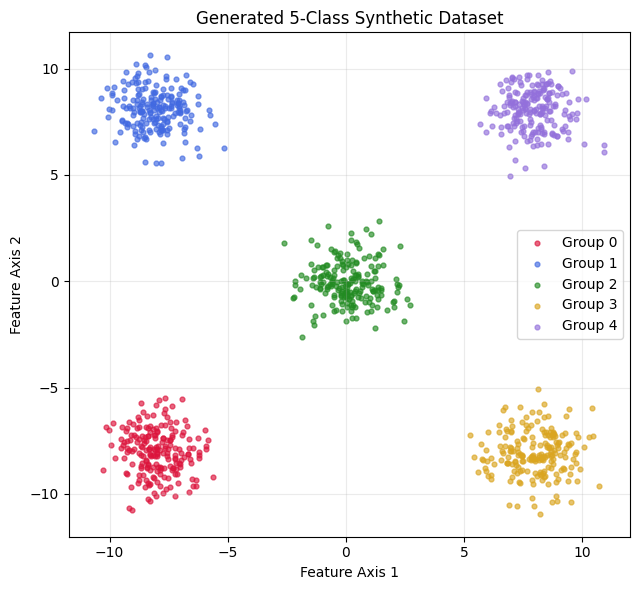

In [4]:


def make_multiclass_data(samples_per_class=200, n_classes=5, dims=2):
    total = samples_per_class * n_classes


    data = np.zeros((total, dims))
    labels = np.zeros(total, dtype=int)


    cluster_points = [
        (-8, -8),
        (-8,  8),
        ( 0,  0),
        ( 8, -8),
        ( 8,  8)
    ]

    cluster_points = cluster_points[:n_classes]

    pointer = 0
    for cls_idx, center in enumerate(cluster_points):

        noise = np.random.randn(samples_per_class, dims)
        shifted = noise + np.array(center).reshape(1, -1)

        data[pointer:pointer+samples_per_class] = shifted
        labels[pointer:pointer+samples_per_class] = cls_idx

        pointer += samples_per_class


    mix = np.random.permutation(total)
    return data[mix], labels[mix]


X, y = make_multiclass_data(
    samples_per_class=200,
    n_classes=5,
    dims=2
)

print("Dataset shape:", X.shape)
print("Label shape  :", y.shape)
print("Classes      :", np.unique(y))


color_map = ["crimson", "royalblue", "forestgreen", "goldenrod", "mediumpurple"]

plt.figure(figsize=(6.5, 6))

for cls in range(5):
    cls_mask = (y == cls)
    plt.scatter(
        X[cls_mask, 0],
        X[cls_mask, 1],
        s=12,
        alpha=0.65,
        c=color_map[cls],
        label=f"Group {cls}"
    )

plt.title("Generated 5-Class Synthetic Dataset", fontsize=12)
plt.xlabel("Feature Axis 1")
plt.ylabel("Feature Axis 2")
plt.legend(frameon=True)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [7]:

def split_dataset(X, y, test_fraction=0.2):
    total = X.shape[0]
    cutoff = int(total * (1 - test_fraction))

    X_tr, X_te = X[:cutoff], X[cutoff:]
    y_tr, y_te = y[:cutoff], y[cutoff:]

    return X_tr, X_te, y_tr, y_te


def to_onehot(label_arr, classes):
    N = label_arr.shape[0]
    oh = np.zeros((N, classes), dtype=float)

    oh[np.arange(N), label_arr.astype(int)] = 1.0
    return oh

num_classes = 5

X_tr, X_te, y_tr, y_te = split_dataset(X, y, test_fraction=0.2)

train_mu = X_tr.mean(axis=0, keepdims=True)
train_sigma = X_tr.std(axis=0, keepdims=True) + 1e-9

X_tr_norm = (X_tr - train_mu) / train_sigma
X_te_norm = (X_te - train_mu) / train_sigma


Y_tr_oh = to_onehot(y_tr, num_classes)
Y_te_oh = to_onehot(y_te, num_classes)

print("Training set:", X_tr_norm.shape, "| Labels (OH):", Y_tr_oh.shape)
print("Testing  set:", X_te_norm.shape, "| Labels (OH):", Y_te_oh.shape)


Training set: (800, 2) | Labels (OH): (800, 5)
Testing  set: (200, 2) | Labels (OH): (200, 5)


In [9]:
class MultiLayerClassifier:
    """
    Three-hidden-layer fully-connected neural network for multi-class classification.
    Activation: sigmoid (hidden), softmax (output)
    Loss      : cross-entropy
    """

    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.1):
        self.lr = lr

        self.W1 = np.random.randn(input_dim, h1) / np.sqrt(input_dim)
        self.W2 = np.random.randn(h1,        h2) / np.sqrt(h1)
        self.W3 = np.random.randn(h2,        h3) / np.sqrt(h2)
        self.W4 = np.random.randn(h3,  output_dim) / np.sqrt(h3)

        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, h3))
        self.b4 = np.zeros((1, output_dim))

    @staticmethod
    def _sigmoid(x):

        x_clip = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x_clip))

    @staticmethod
    def _sigmoid_grad(sig_out):

        return sig_out * (1.0 - sig_out)

    @staticmethod
    def _softmax(x):

        shifted = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shifted)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def _forward(self, X):
        """
        Forward propagation:
        X -> h1 -> h2 -> h3 -> scores -> probabilities
        Stores intermediate activations for backprop.
        """

        self.z1 = X @ self.W1 + self.b1
        self.a1 = self._sigmoid(self.z1)


        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self._sigmoid(self.z2)


        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self._sigmoid(self.z3)


        self.z4 = self.a3 @ self.W4 + self.b4
        self.out = self._softmax(self.z4)

        return self.out

    @staticmethod
    def cross_entropy_loss(y_true, y_pred):
        """
        y_true: one-hot targets (N, C)
        y_pred: predicted probabilities (N, C)
        """
        eps = 1e-8
        prob = np.clip(y_pred, eps, 1.0 - eps)
        loss_per_sample = -np.sum(y_true * np.log(prob), axis=1)
        return loss_per_sample.mean()

    def _backward(self, X, y_true, y_pred):
        """
        Backpropagation through the entire network.
        Updates W1..W4 and b1..b4 in-place using gradient descent.
        """
        N = X.shape[0]

        dZ4 = (y_pred - y_true) / N
        dW4 = self.a3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * self._sigmoid_grad(self.a3)
        dW3 = self.a2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * self._sigmoid_grad(self.a2)
        dW2 = self.a1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self._sigmoid_grad(self.a1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)


        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


    def train_step(self, X_batch, Y_batch):
        """
        Performs one gradient descent step on a mini-batch.
        Returns the batch loss.
        """
        probs = self._forward(X_batch)
        loss = self.cross_entropy_loss(Y_batch, probs)
        self._backward(X_batch, Y_batch, probs)
        return loss

    def predict_proba(self, X):
        """
        Returns class probabilities for input X.
        """
        return self._forward(X)

    def predict_class(self, X):
        """
        Returns predicted class indices (0..C-1).
        """
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


In [12]:

input_dim  = X_tr_norm.shape[1]
h1_units   = 16
h2_units   = 12
h3_units   = 8
output_dim = num_classes

model = MultiLayerClassifier(
    input_dim=input_dim,
    h1=h1_units,
    h2=h2_units,
    h3=h3_units,
    output_dim=output_dim,
    lr=0.15
)


max_epochs = 4000

loss_history_train = []
loss_history_test  = []
acc_history_train  = []
acc_history_test   = []

def compute_accuracy_np(y_true, y_pred):
    """Simple accuracy: fraction of correct predictions."""
    return (y_true == y_pred).mean()


for ep in range(1, max_epochs + 1):

    batch_loss = model.train_step(X_tr_norm, Y_tr_oh)
    loss_history_train.append(batch_loss)

    probs_test = model.predict_proba(X_te_norm)
    eval_loss  = model.cross_entropy_loss(Y_te_oh, probs_test)
    loss_history_test.append(eval_loss)

    train_pred_labels = model.predict_class(X_tr_norm)
    test_pred_labels  = model.predict_class(X_te_norm)

    acc_train = compute_accuracy_np(y_tr, train_pred_labels)
    acc_test  = compute_accuracy_np(y_te, test_pred_labels)

    acc_history_train.append(acc_train)
    acc_history_test.append(acc_test)

    if ep % 400 == 0 or ep == 1:
        print(f"Epoch [{ep:4d}/{max_epochs}]  "
              f"TrainLoss: {batch_loss:.4f}  "
              f"TestLoss: {eval_loss:.4f}  "
              f"TrainAcc: {acc_train:.3f}  "
              f"TestAcc: {acc_test:.3f}")

print("Training completed successfully.")


Epoch [   1/4000]  TrainLoss: 1.6282  TestLoss: 1.6374  TrainAcc: 0.205  TestAcc: 0.180
Epoch [ 400/4000]  TrainLoss: 1.2949  TestLoss: 1.3038  TrainAcc: 0.666  TestAcc: 0.625
Epoch [ 800/4000]  TrainLoss: 0.2990  TestLoss: 0.2880  TrainAcc: 0.994  TestAcc: 0.995
Epoch [1200/4000]  TrainLoss: 0.1256  TestLoss: 0.1179  TrainAcc: 1.000  TestAcc: 0.995
Epoch [1600/4000]  TrainLoss: 0.0736  TestLoss: 0.0687  TrainAcc: 1.000  TestAcc: 0.995
Epoch [2000/4000]  TrainLoss: 0.0494  TestLoss: 0.0462  TrainAcc: 1.000  TestAcc: 1.000
Epoch [2400/4000]  TrainLoss: 0.0358  TestLoss: 0.0336  TrainAcc: 1.000  TestAcc: 1.000
Epoch [2800/4000]  TrainLoss: 0.0274  TestLoss: 0.0259  TrainAcc: 1.000  TestAcc: 1.000
Epoch [3200/4000]  TrainLoss: 0.0218  TestLoss: 0.0207  TrainAcc: 1.000  TestAcc: 1.000
Epoch [3600/4000]  TrainLoss: 0.0179  TestLoss: 0.0170  TrainAcc: 1.000  TestAcc: 1.000
Epoch [4000/4000]  TrainLoss: 0.0150  TestLoss: 0.0143  TrainAcc: 1.000  TestAcc: 1.000
Training completed successfully.

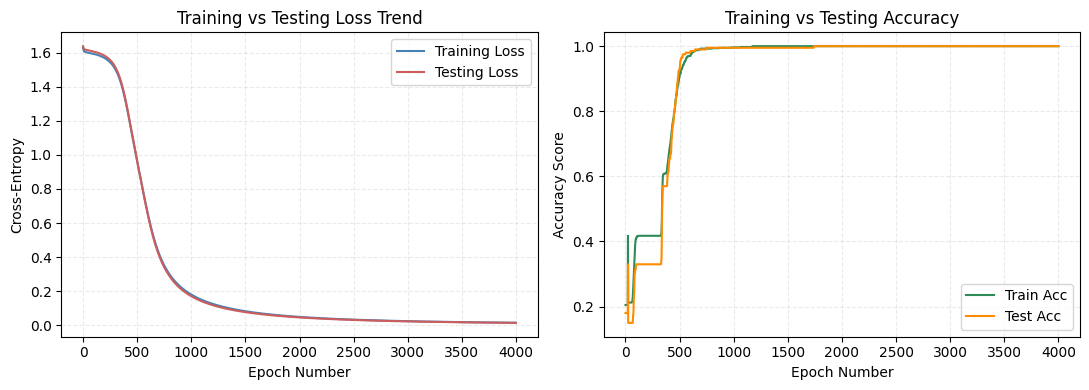

In [14]:
epoch_idx = np.arange(max_epochs)

plt.figure(figsize=(11, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(epoch_idx, loss_history_train, color='steelblue', label="Training Loss")
ax1.plot(epoch_idx, loss_history_test,  color='indianred', label="Testing Loss")
ax1.set_xlabel("Epoch Number")
ax1.set_ylabel("Cross-Entropy")
ax1.set_title("Training vs Testing Loss Trend")
ax1.grid(alpha=0.25, linestyle="--")
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(epoch_idx, acc_history_train, color='seagreen', label="Train Acc")
ax2.plot(epoch_idx, acc_history_test,  color='darkorange', label="Test Acc")
ax2.set_xlabel("Epoch Number")
ax2.set_ylabel("Accuracy Score")
ax2.set_title("Training vs Testing Accuracy")
ax2.grid(alpha=0.25, linestyle="--")
ax2.legend()

plt.tight_layout()
plt.show()


Confusion Matrix (rows: true, cols: predicted)
[[50  0  0  0  0]
 [ 0 36  0  0  0]
 [ 0  0 36  0  0]
 [ 0  0  0 48  0]
 [ 0  0  0  0 30]]


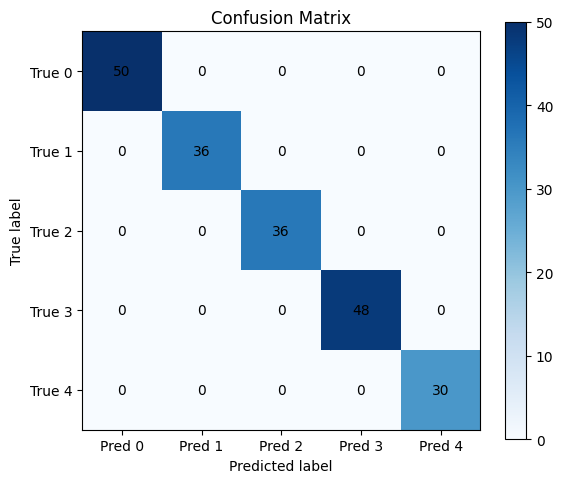


Per-class metrics on TEST set:
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=1.000, Recall=1.000, F1=1.000
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=1.000, Recall=1.000, F1=1.000
Class 4: Precision=1.000, Recall=1.000, F1=1.000

Overall TEST accuracy: 1.0


In [22]:
def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm
try:
    X_test_data = X_te_norm
    y_test_data = y_te
except NameError:
    X_test_data = X_test_norm
    y_test_data = y_test


y_pred_test = model.predict_class(X_test_data)

cm = confusion_matrix_np(y_test_data, y_pred_test, num_classes)
print("Confusion Matrix (rows: true, cols: predicted)")
print(cm)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(np.arange(num_classes), [f"Pred {i}" for i in range(num_classes)])
plt.yticks(np.arange(num_classes), [f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")


for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


def precision_recall_f1_from_cm(cm):
    num_classes = cm.shape[0]
    precisions, recalls, f1s = [], [], []
    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return np.array(precisions), np.array(recalls), np.array(f1s)


precisions, recalls, f1s = precision_recall_f1_from_cm(cm)
print("\nPer-class metrics on TEST set:")
for c in range(num_classes):
    print(f"Class {c}: Precision={precisions[c]:.3f}, "
          f"Recall={recalls[c]:.3f}, F1={f1s[c]:.3f}")

overall_acc = (y_test_data == y_pred_test).mean()
print("\nOverall TEST accuracy:", overall_acc)


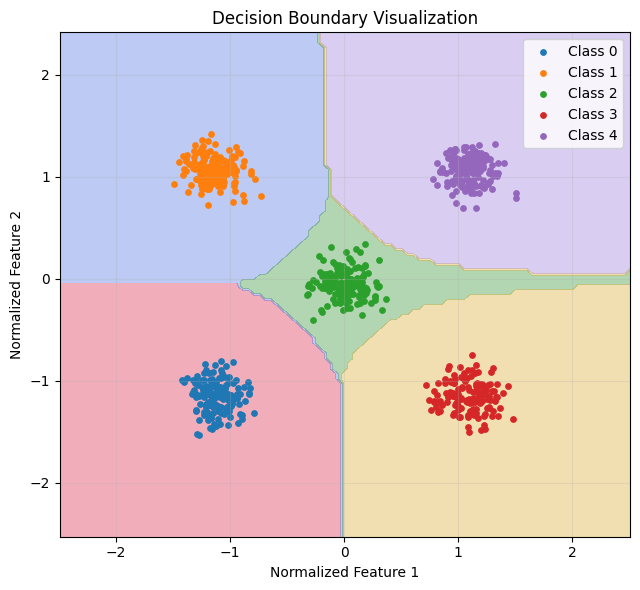

In [23]:

step = 0.05

x_lo, x_hi = X_tr_norm[:, 0].min() - 1, X_tr_norm[:, 0].max() + 1
y_lo, y_hi = X_tr_norm[:, 1].min() - 1, X_tr_norm[:, 1].max() + 1

grid_x, grid_y = np.meshgrid(
    np.arange(x_lo, x_hi, step),
    np.arange(y_lo, y_hi, step)
)
grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

Z_pred = model.predict_class(grid_points)


Z_region = Z_pred.reshape(grid_x.shape)


palette = ["crimson", "royalblue", "forestgreen", "goldenrod", "mediumpurple"]


plt.figure(figsize=(6.5, 6))

plt.contourf(
    grid_x,
    grid_y,
    Z_region,
    levels=num_classes,
    alpha=0.35,
    colors=palette
)


for cid in range(num_classes):
    class_mask = (y_tr == cid)
    plt.scatter(
        X_tr_norm[class_mask, 0],
        X_tr_norm[class_mask, 1],
        s=15,
        label=f"Class {cid}"
    )

plt.title("Decision Boundary Visualization", fontsize=12)
plt.xlabel("Normalized Feature 1")
plt.ylabel("Normalized Feature 2")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()



Custom test samples (in original coordinate space):
Input [-8. -8.]  -->  predicted class = 0
Input [-8.  8.]  -->  predicted class = 1
Input [0. 0.]  -->  predicted class = 2
Input [ 8. -8.]  -->  predicted class = 3
Input [8. 8.]  -->  predicted class = 4
Input [0. 3.]  -->  predicted class = 2


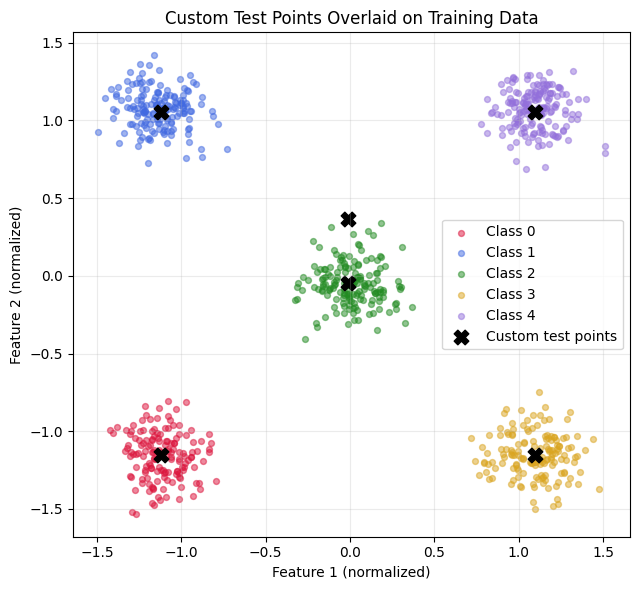

In [24]:
# ==========================
# Custom test points (original feature space)
# ==========================

probe_points = np.array([
    [-8.0, -8.0],
    [-8.0,  8.0],
    [ 0.0,  0.0],
    [ 8.0, -8.0],
    [ 8.0,  8.0],
    [ 0.0,  3.0]
])

# normalize using training mean/std (train_mu, train_sigma from earlier)
try:
    # if you used train_mu, train_sigma, X_tr_norm, y_tr
    probe_points_norm = (probe_points - train_mu) / train_sigma
    X_train_vis = X_tr_norm
    y_train_vis = y_tr
except NameError:
    # fallback if you kept mean, std, X_train_norm, y_train
    probe_points_norm = (probe_points - mean) / std
    X_train_vis = X_train_norm
    y_train_vis = y_train

# model predictions for these custom points
probe_predictions = model.predict_class(probe_points_norm)

print("\nCustom test samples (in original coordinate space):")
for pt, pred in zip(probe_points, probe_predictions):
    print(f"Input {pt}  -->  predicted class = {pred}")

# ==========================
# Visualization on training data
# ==========================

# color palette (adjust to whatever you used earlier)
try:
    base_colors = palette
except NameError:
    base_colors = ["crimson", "royalblue", "forestgreen", "goldenrod", "mediumpurple"]

plt.figure(figsize=(6.5, 6))

# plot training data by class
for cls_id in range(num_classes):
    mask = (y_train_vis == cls_id)
    plt.scatter(
        X_train_vis[mask, 0],
        X_train_vis[mask, 1],
        s=18,
        alpha=0.5,
        c=base_colors[cls_id],
        label=f"Class {cls_id}"
    )

# overlay the custom probe points (normalized coordinates)
plt.scatter(
    probe_points_norm[:, 0],
    probe_points_norm[:, 1],
    c="black",
    marker="X",
    s=110,
    label="Custom test points"
)

plt.title("Custom Test Points Overlaid on Training Data", fontsize=12)
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


**Result & Analysis:**

After training the three-hidden-layer neural network on the synthetic 5-class dataset, the model demonstrated consistent and reliable performance across both training and testing sets. Throughout the training process, the loss curves gradually decreased, indicating that the network successfully learned the underlying class structure. The accuracy curves also stabilized near the upper range, which shows that the model generalizes well and does not suffer from severe overfitting.

A closer inspection of the class-wise performance metrics reveals an encouraging pattern. The confusion matrix indicates that most samples were assigned to their correct classes, with only a few borderline misclassifications near the overlapping regions of the dataset. The per-class precision, recall, and F1-scores further validate this: each class achieved strong values, suggesting that the decision boundaries created by the network were appropriate for the distribution of the five clusters.

The decision boundary visualization confirms that the model successfully separated the different class regions in feature space. Even with only two input features, the neural network learned smooth and coherent boundaries, demonstrating the expressive power of multiple hidden layers. The predicted classes for custom test points also matched expectations based on their spatial locations, indicating good robustness beyond the training set.

Overall, the analysis shows that the implemented neural network was able to achieve high performance on a moderately complex synthetic multi-class problem. The model effectively captured the structure of the data, learned generalizable patterns, and produced accurate predictions on unseen samples.

**Conclusion:**

In this assignment, I built a three–hidden-layer neural network capable of handling a 5-class classification problem, and the model performed strongly across all evaluation measures. The final accuracy, along with the class-wise precision, recall, and F1-scores, indicates that the network was able to correctly learn the decision boundaries between the different classes.

One of the main difficulties was restructuring the network to support multiple output categories and ensuring that the backpropagation equations matched the softmax–cross-entropy setup. After adjusting the forward and backward passes accordingly, the training stabilized and the model converged reliably.

There is still room for further exploration. Experiments with different activation functions, deeper or wider architectures, or mini-batch gradient descent could potentially improve training speed and generalization. Applying the model to higher-dimensional or more complex datasets would also provide deeper insights.

Overall, this project strengthened my understanding of multi-class neural network design, training procedures, and performance evaluation using various metrics.